In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import pandas as pd

from sklearn import preprocessing
import datetime
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree


from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_regression

os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.style.use('fivethirtyeight')

In [2]:
pd.options.mode.chained_assignment = None 

## Leamos los DF generados

Leemos los archivos por hora:

In [144]:
data_hora_12 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2012.csv')
#data_hora_13 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2013.csv')
data_hora_14 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2014.csv')
data_hora_15 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2015.csv')
data_hora_16 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2016.csv')
data_hora_17 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2017.csv')

In [145]:
data_hora_17 = data_hora_17.append(data_hora_16, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_15, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_14, ignore_index=True)
#data_hora_17 = data_hora_17.append(data_hora_13, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_12, ignore_index=True)

In [146]:
data_hora = data_hora_17

In [147]:
data_hora['dia'] = data_hora['fecha'].astype(str).str[8:10]
data_hora['mes'] =  data_hora['fecha'].astype(str).str[5:7]

In [148]:
data_hora['fecha'] = data_hora['fecha'].astype(str).str[0:10]

In [149]:
data_hora = data_hora.drop(["Unnamed: 0"],axis=1)
data_hora = data_hora.drop_duplicates()
data_hora = data_hora[1::]

In [152]:
data_hora.id_station.unique()

array(['MER', 'TLA'], dtype=object)

In [150]:
data_hora[data_hora.O3>150]

,fecha,hora,dia,mes,id_station,UVA,UVB,PA,CO,NO,...,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
9052,2016-05-02,16,02,05,TLA,0.000,0.000,580.0,0.8,3.0,...,32.0,167.0,52.0,29.0,4.0,10.0,29.6,1.7,135.0,81.0
9054,2016-05-02,17,02,05,TLA,0.000,0.000,580.0,0.7,1.0,...,30.0,156.0,41.0,29.0,3.0,11.0,29.3,1.3,153.0,70.0
9455,2016-05-03,14,03,05,TLA,0.000,0.000,582.0,1.0,3.0,...,33.0,168.0,81.0,32.0,4.0,20.0,28.2,0.8,169.0,114.0
9457,2016-05-03,15,03,05,TLA,0.000,0.000,581.0,0.9,2.0,...,29.0,163.0,81.0,37.0,3.0,20.0,28.5,2.0,137.0,117.0
15468,2016-05-20,17,20,05,TLA,0.000,0.000,582.0,0.7,2.0,...,36.0,162.0,33.0,29.0,3.0,16.0,28.5,1.8,202.0,61.0
20926,2015-10-04,15,04,10,TLA,2.653,1.869,581.0,1.0,4.0,...,37.0,151.0,46.0,32.0,5.0,30.0,24.5,2.1,325.0,78.0
35078,2014-02-20,16,20,02,TLA,2.072,1.074,580.0,0.7,3.0,...,37.0,158.0,53.0,50.0,5.0,22.0,24.5,1.5,122.0,103.0
35080,2014-02-20,17,20,02,TLA,0.984,0.377,580.0,1.0,7.0,...,57.0,151.0,68.0,86.0,6.0,22.0,24.9,1.2,349.0,154.0
35120,2014-03-20,17,20,03,TLA,1.303,0.576,581.0,1.0,6.0,...,48.0,155.0,63.0,49.0,11.0,29.0,25.1,0.8,31.0,112.0
38960,2012-03-02,16,02,03,TLA,2.310,1.230,579.0,1.1,6.0,...,60.0,158.0,64.0,44.0,8.0,20.0,27.0,0.2,98.0,108.0



# Datos por día: mean(), max(), min()

### Creamos un Df con los datos promedio por hora oara rellenar los nan del DF original

In [10]:
means = data_hora.groupby(['fecha',"hora"]).transform('mean')

In [11]:
data_hora = data_hora.fillna(means)

 Create a datetime column

In [12]:
data_hora['fecha']  = pd.to_datetime([''.join([' '.join([data_hora.loc[i, 'fecha'], str(data_hora.loc[i, 'hora'])]),':00']) for i in data_hora.index])

 We can now drop the scalar date and hour columns

Sort into proper order so that rolling() is computed correctly


In [13]:
data_24 = data_hora.sort_values(['id_station','fecha'])
# Set the datetime column as the dataframe index
data_24 = data_24.set_index('fecha')

In [14]:
data_24 = data_24.groupby('id_station')["PM10","PM2.5"].rolling(24).mean().dropna().reset_index()

In [15]:
data_24 = data_24.rename(columns={'PM10': 'PM10_mean', 'PM2.5': 'PM2.5_mean'})

## Groupbys

MIN

In [16]:
data_min = data_hora.groupby(['fecha',"id_station","hora"])['UVA', 'UVB', 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10'].min()
data_min.reset_index(inplace=True)
#data_min.drop(["id_station"],axis=1,inplace=True)

Max

In [17]:
data_max = data_hora.groupby(['fecha',"id_station","hora"])['UVA', 'UVB', 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10'].max()
data_max.reset_index(inplace=True)
#data_max.drop(["id_station"],axis=1,inplace=True)

### Merge

In [18]:
data_day = pd.merge(data_min, data_max, on=["fecha","id_station","hora"])

In [19]:
data_day = pd.merge(data_day, data_hora, on=["fecha","id_station","hora"])
#data_day.drop(["id_station"],axis=1,inplace=True)

In [20]:
data_day = pd.merge(data_day, data_24, on=["fecha","id_station"])

In [21]:
data_day.head()

,fecha,id_station,hora,UVA_x,UVB_x,PA_x,CO_x,NO_x,NO2_x,NOX_x,...,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10,PM10_mean,PM2.5_mean
0,2012-01-01 23:00:00,MER,23,0.0,0.0,590.0,0.4,5.0,18.0,23.0,...,10.0,9.0,2.0,64.0,12.3,4.1,348.0,19.0,96.666667,64.291667
1,2012-01-02 00:00:00,MER,0,0.0,0.0,592.0,0.4,3.0,20.0,23.0,...,7.0,11.0,2.0,64.0,8.3,3.7,303.0,18.0,96.750000,64.208333
2,2012-01-02 01:00:00,MER,1,0.0,0.0,590.0,0.2,1.0,11.0,12.0,...,5.0,3.0,2.0,66.0,12.1,3.7,346.0,8.0,93.333333,61.833333
3,2012-01-02 02:00:00,MER,2,0.0,0.0,590.0,0.2,1.0,9.0,10.0,...,9.0,3.0,2.0,66.0,11.9,3.4,330.0,12.0,87.666667,57.958333
4,2012-01-02 03:00:00,MER,3,0.0,0.0,590.0,0.2,0.0,9.0,8.0,...,2.0,3.0,2.0,67.0,11.9,2.8,341.0,6.0,81.416667,53.416667


## Añadimos Precipitación que solo esta en días:

In [22]:
prec_2017 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2017PPH.xls')
prec_2016 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2016PPH.xls')
prec_2015 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2015PPH.xls')
prec_2014 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2014PPH.xls')
prec_2013 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2013PPH.xls')
prec_2012 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2012PPH.xls')

In [23]:
prec_2017 = prec_2017.append(prec_2016, ignore_index=True)
prec_2017 = prec_2017.append(prec_2015, ignore_index=True)
prec_2017 = prec_2017.append(prec_2014, ignore_index=True)
prec_2017 = prec_2017.append(prec_2013, ignore_index=True)
prec_2017 = prec_2017.append(prec_2012, ignore_index=True)

In [24]:
prec = prec_2017.where(prec_2017.LOM != -99.00) #Los valores vacíos vienen como -99, vamos a eliminarlos:
prec = prec.dropna()

In [25]:
prec = prec.rename(columns={'FECHA': 'fecha'}) #Renombramos algunas columnas:

Transponemos el df:

In [26]:
prec = pd.melt(prec, id_vars=["fecha"], 
                   var_name="id_station",value_name="Precip")

In [27]:
prec['fecha'] =  pd.to_datetime(prec['fecha'], format='%Y-%m-%d %H:%M')

## Lo unimos con el archivo ya generado:

In [28]:
data_day["fecha"] =  pd.to_datetime(data_day["fecha"], format='%Y-%m-%d %H:%M')

In [29]:
data_day_avg = pd.merge(data_day, prec, on=["fecha","id_station"],  how='left')

In [30]:
data_day_avg = data_day_avg.fillna(0)

In [31]:
data_day_avg["dia"] = pd.DatetimeIndex(data_day_avg['fecha']).day
data_day_avg["mes"] = pd.DatetimeIndex(data_day_avg['fecha']).month

In [32]:
#data_day_avg.drop(["id_station_x","id_station_y"],axis=1,inplace=True)

### Definamos el Timeshift

In [100]:
del data_hour_merge_24

In [101]:
data_hour_merge_24 = data_day_avg

In [102]:
data_hour_merge_24["PM10_frcst"] = data_hour_merge_24.O3.shift(12)
data_hour_merge_24["PM10_frcst_1"] = data_hour_merge_24.O3.shift(-1)
data_hour_merge_24["PM10_frcst_1"] = data_hour_merge_24.O3.shift(-2)
data_hour_merge_24["PM10_frcst_1"] = data_hour_merge_24.O3.shift(-3)
data_hour_merge_24["PM10_frcst_1"] = data_hour_merge_24.O3.shift(-12)
data_hour_merge_24["PM10_frcst_1"] = data_hour_merge_24.O3.shift(-6)


data_hour_merge_24["PM10_1_a"] = data_hour_merge_24.PM10.shift(-1)
data_hour_merge_24["PM10_2_a"] = data_hour_merge_24.PM10.shift(-2)
data_hour_merge_24["PM10_3_a"] = data_hour_merge_24.PM10.shift(-3)
data_hour_merge_24["PM10_4_a"] = data_hour_merge_24.PM10.shift(-4)

data_hour_merge_24["PM10_2_y"] = data_hour_merge_24.PM10_y.shift(-2)
data_hour_merge_24["PM10_3_y"] = data_hour_merge_24.PM10_y.shift(-3)
data_hour_merge_24["PM10_4_y"] = data_hour_merge_24.PM10_y.shift(-4)

data_hour_merge_24["PM10_1_x"] = data_hour_merge_24.PM10_x.shift(1)
data_hour_merge_24["PM10_2_x"] = data_hour_merge_24.PM10_x.shift(2)
data_hour_merge_24["PM10_3_x"] = data_hour_merge_24.PM10_x.shift(3)
data_hour_merge_24["PM10_3_x"] = data_hour_merge_24.PM10_x.shift(3)
data_hour_merge_24["PM10_4_x"] = data_hour_merge_24.PM10_x.shift(4)

data_hour_merge_24["temp_24"] = data_hour_merge_24.TMP.shift(-1)
data_hour_merge_24["pre_24"] = data_hour_merge_24.PA.shift(-1)
data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)

data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)

data_hour_merge_24["UVB_x_1"] = data_hour_merge_24.UVB_x.shift(-1)
data_hour_merge_24["UVB_x_2"] = data_hour_merge_24.UVB_x.shift(-2)
data_hour_merge_24["UVB_y_1"] = data_hour_merge_24.UVB_y.shift(-1)
data_hour_merge_24["UVB_y_2"] = data_hour_merge_24.UVB_y.shift(-2)

#data_MGH_18 = data_MGH_18.iloc[:,:-6]

In [103]:
data_hour_merge_24.head()

,hora,UVA_x,UVB_x,PA_x,CO_x,NO_x,NO2_x,NOX_x,O3_x,PM2.5_x,...,PM10_3_x,PM10_4_x,temp_24,pre_24,RH_24,RH_24_2,UVB_x_1,UVB_x_2,UVB_y_1,UVB_y_2
0,23,0.0,0.0,590.0,0.4,5.0,18.0,23.0,15.0,10.0,...,NaN,NaN,8.3,592.0,64.0,66.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,592.0,0.4,3.0,20.0,23.0,15.0,7.0,...,NaN,NaN,12.1,590.0,66.0,66.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,590.0,0.2,1.0,11.0,12.0,18.0,5.0,...,NaN,NaN,11.9,590.0,66.0,67.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,590.0,0.2,1.0,9.0,10.0,18.0,9.0,...,19.0,NaN,11.9,590.0,67.0,70.0,0.0,0.0,0.0,0.0
4,3,0.0,0.0,590.0,0.2,0.0,9.0,8.0,17.0,2.0,...,18.0,19.0,11.2,590.0,70.0,67.0,0.0,0.0,0.0,0.0


In [104]:
data_hour_merge_24.drop(["fecha","id_station"],axis=1,inplace=True)

KeyError: "labels ['fecha' 'id_station'] not contained in axis"

In [105]:
data_hour_merge_24 = data_hour_merge_24.dropna(how='any')

In [106]:
data_hour_merge_24['dia'] = data_hour_merge_24['dia'].astype(str).astype(float)
data_hour_merge_24['mes'] = data_hour_merge_24['mes'].astype(str).astype(float)

## Visualizaciones    <a class="anchor" id="viz-bullet"></a>

# Modelos de Machine Learning y Neural Networks

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [107]:
X = data_hour_merge_24.loc[:, data_hour_merge_24.columns != 'PM10_frcst']
y = data_hour_merge_24["PM10_frcst"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

## Linear

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create linear regression object
regr = LinearRegression()

In [113]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [114]:
# Make predictions using the testing set
lin_pred = regr.predict(X_test)

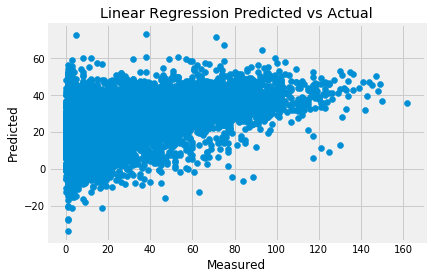

In [115]:
plt.scatter(y_test, lin_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Linear Regression Predicted vs Actual')
plt.show()

In [116]:
regr.score(X_test, y_test)

0.2288753153166816

## Neural Network Regression

In [86]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
mlp = MLPRegressor( alpha=900.001, max_iter=100000,power_t=301, epsilon=.100 ,tol=.0001)
# Train the model using the training sets
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=900.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=0.1,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=301, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

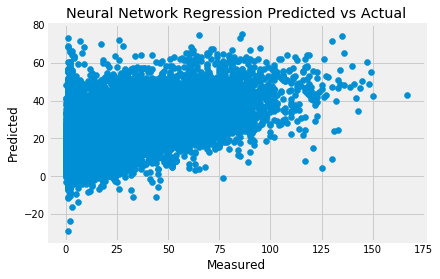

In [87]:
# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
neural_network_regression_score
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)
# The mean squared error

plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

In [88]:
xgb_score = mlp.score(X_test, y_test)
xgb_score

0.29766001672855946

# XGBoost

In [89]:
from xgboost.sklearn import XGBRegressor

#Fitting XGB regressor 
xboost = XGBRegressor(learning_rate = .0015, n_estimators=300, max_depth=10)

In [90]:
xboost.fit(X_train, y_train)
xgb_score = xboost.score(X_test, y_test)

/home/paw/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [91]:
#Predict 
xboost_pred = xboost.predict(X_test)

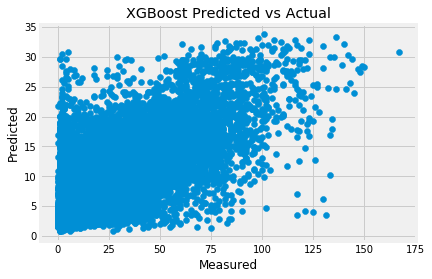

In [92]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [93]:
xgb_score = xboost.score(X_test, y_test)
xgb_score

-0.06227714418638675

## Decission Tree

In [719]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=10,max_depth=3000)

In [720]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3000, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [721]:
xboost_pred = regressor.predict(X_test)

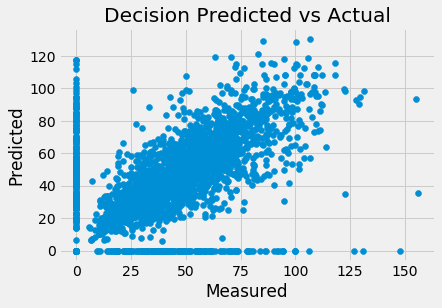

In [722]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Decision Predicted vs Actual')
plt.show()

In [723]:
regressor.score(X_test, y_test)

0.5771694344229061

# ada

In [59]:
regr_x = AdaBoostRegressor(XGBRegressor(learning_rate = .0015, n_estimators=3000, max_depth=10),n_estimators=300)


X = X_train
y = y_train
regr_x.fit(X, y)

KeyboardInterrupt: 

In [ ]:
y_1 = regr_x.predict(X_test)

In [ ]:
plt.scatter(y_test, y_1)
plt.tight_layout(1.3)
plt.xlabel('PM10: Medido')
plt.ylabel('PM10: Pronosticado')
plt.title('ADA: Pronosticado vs Medio')
plt.savefig('/Users/danielbustillos/Desktop/Pem10.png', dpi=900)
plt.show()

In [ ]:
regr_x.score(X_test, y_test)

## ADA Booster applied on Decision Tree Regressor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=40),n_estimators=3000)


X = X_train
y = y_train
regr_2.fit(X, y)


y_2 = regr_2.predict(X_test)


In [ ]:
plt.scatter(y_test, y_2)
plt.tight_layout(1.3)
plt.xlabel('PM10: Medido')
plt.ylabel('PM10: Pronosticado')
plt.title('ADA: Pronosticado vs Medio')
plt.savefig('/Users/danielbustillos/Desktop/Pem10.png', dpi=900)
plt.show()

In [ ]:
y_1 = regr_1.predict(X_test)


In [ ]:
X, y = data_hour_merge_24.iloc[:,:-1],data_hour_merge_24.iloc[:,-1]

In [ ]:
preds = y_1.tolist()

In [ ]:
yi = y_test.tolist()

In [ ]:
y;

In [ ]:
>>> plt.plot(preds ,label='PM10 Pronosticado')
>>> plt.plot(yi,label='PM10 Medido')
>>> plt.xlabel("Febrero 2018")
>>> plt.ylabel("PM10")
plt.tight_layout(1.3)
plt.title('Comparación de Modelo')
>>> plt.xlim(31, 60)
plt.legend()
plt.savefig('/Users/danielbustillos/Desktop/Pm10.png', dpi=900)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_2))
print("RMSE: %f" % (rmse))

In [ ]:
regr_2.score(X_test, y_test)

## Random forest

In [94]:
regr = RandomForestRegressor(max_depth=10,n_estimators=10,random_state=0)

In [95]:
regr_fit = regr.fit(X_train, y_train)

In [96]:
y_1 = regr.predict(X_test)

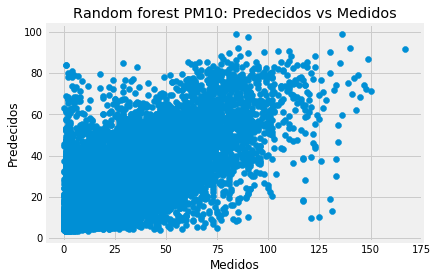

In [97]:
plt.scatter(y_test, y_1)
plt.xlabel('Medidos')
plt.ylabel('Predecidos')
plt.title('Random forest PM10: Predecidos vs Medidos')
plt.show()

In [98]:
regr.score(X_test, y_test)

0.5150964806449072

In [183]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(regr.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [184]:
importances;

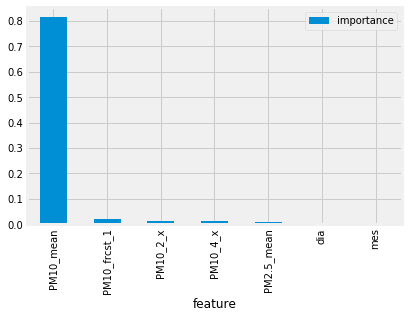

In [185]:
importances[importances.importance > .005].plot.bar()


### ADA Randomforest